# Quantum Counting using the Iterative Quantum Amplitude Estimation Algorithm

Quantum Counting algorithm [[1](#QCWiki)] is an algorithm for efficiently estimating the number of valid solutions to a search problem, based on the amplitude estimation algorithm. It demonstrates a quadratic improvement with regards to a classical algorithm with black-box oracle access to the function $f$.

More precisely, the counting problem is, given a boolean function $f :\{0, 1\}^n\rightarrow\{0,1\}$, estimate the number of inputs $x$ to $f$ such that $f(x)=1$.

In this tutorial we will deomstrate how to estimate the Couting problem using a specific variant of the Amplitude Estimation algorithm - the Iterative Quantum Amplitude Estimation (IQAE) [[2](#IQAE)].

The IQAE does not rely on the Quantum Phase Estimation algoritm [[3](#AE)], but purely on applications of the grover operator:
$$
Q\equiv -  A S_0 A^{\dagger} S_{\psi_1} ,
$$
Hence reducing the required amount of qubits and gates of the circuit, at the expense of additional multiplicative factor poly-logarithmic in the error $\epsilon$.


## Setting the problem

We will choose the equation:
$$
(a + b) <= 2
$$
where $a$, $b$ are 2-bit unsigned integers. This equation has 6 solutions. The goal is to estimate the number of valid solutions out of the 16 possible inputs, with precision $0.5$.




## Amplitude Estimation using Phase Estimation

We first show how to use Quantum Phase Estimation algorithm for the Quantum Counting [[3](#AE)], then move to solve it using the IQAE method.

Given a state $|\psi\rangle$ such that $|\psi\rangle=\sqrt{a}|\psi_1\rangle+\sqrt{1-a}|\psi_0\rangle$ we can measure $a$ up to arbitrary precision, given the following building blocks:
1) State Preperation: 
A unitary $A$ such that: $A|0\rangle = |\psi\rangle = \sqrt{a}|\psi_1\rangle+\sqrt{1-a}|\psi_0\rangle$


2) Oracle:
A unitary $S_{\psi_1}$ such that $S_{\psi_1}=I-2|\psi_1\rangle\langle\psi_1|$, which adds a $(-1)$ phase to $|\psi_1|\psi\rangle\rangle$ and does nothing to any orthognal states to $|\psi_1\rangle$.
This is effectively a reflection around the "good" state $|\psi_1\rangle$.

Given this 2 functions, we can construct the grover operator:
$$
Q\equiv -  A S_0 A^{\dagger} S_{\psi_1} ,
$$
Which is exactly the same operator as the one for the grover's search algorithm. 


In the subspace spanned by $|\psi_1\rangle$ and $|\psi_0\rangle$, $Q$ has 2 eigenvalues: 
$$
\lambda_{\pm}=\exp\left(\pm i2\pi \theta \right), \qquad \sin^2 \left(\pi \theta\right)\equiv a.
$$

Therefore, if we apply a QPE on $A|0\rangle$ we will have these two eigenvalues encoded in the QPE register, however, both give the value of $a$, so there is no ambiguity here.

### Arithmetic oracle

Here we define the $S_{\psi_1}$ oracle:

$$
S_{\psi_1}|a\rangle|b\rangle= (-1)^{f(a,b)}|a\rangle|b\rangle
$$

In [1]:
from classiq.qmod import H, QArray, QBit, QNum, Z, qfunc, within_apply

A_SIZE = 2
B_SIZE = 2
DOMAIN_SIZE = A_SIZE + B_SIZE


@qfunc
def arith_equation(a: QNum, b: QNum, res: QBit):
    res ^= a + b <= 2


# use phase kickback for turning the arith_equation to an oracle
@qfunc
def arith_oracle(a: QNum, b: QNum):
    aux = QBit("aux")
    within_apply(
        lambda: (allocate(1, aux), X(aux), H(aux)), lambda: arith_equation(a, b, aux)
    )

### Diffuser

The diffuser consists of the reflection around the $|0\rangle$ state, and a state-preparation function.

The state preparation function $A$ reflects knowledge about the solution space, and can be used to eliminate invalid assignments. Here we assume no knowledge on the solution space, hence we use the uniform superposition state preparation.

In [2]:
import numpy as np

from classiq.qmod import (
    QCallable,
    U,
    X,
    apply_to_all,
    bind,
    control,
    hadamard_transform,
    invert,
    within_apply,
)


@qfunc
def reflection_about_zero(x: QArray[QBit]):
    lsb = QBit("lsb")
    msbs = QArray("msbs", QBit, x.len - 1)

    apply_to_all(X, x)
    bind(x, [msbs, lsb])
    control(msbs, lambda: Z(lsb))
    bind([msbs, lsb], x)
    apply_to_all(X, x)


@qfunc
def my_diffuser(sp_operand: QCallable[QArray[QBit]], x: QArray[QBit]):
    within_apply(
        lambda: invert(lambda: sp_operand(x)),
        lambda: reflection_about_zero(x),
    )


sp_oracle = lambda x: hadamard_transform(x)

### Complete Grover operator definition

In [3]:
@qfunc
def my_grover_operator(
    oracle_operand: QCallable[QArray[QBit]],
    sp_operand: QCallable[QArray[QBit]],
    x: QArray[QBit],
):
    oracle_operand(x)
    my_diffuser(sp_operand, x)
    U(0, 0, 0, np.pi, x[0])

### Wrap all to the Phase Estimation

We will acheive the desired precision only in the IQAE phase. Here we compute the worst-case precision for 5 phase qubits:

In [4]:
NUM_PHASE_QUBITS = 5

x = np.linspace(0, 1, 100)
(2**DOMAIN_SIZE) * max(
    np.abs(
        np.sin(np.pi * x) ** 2 - np.sin(np.pi * (x - 1 / (2**NUM_PHASE_QUBITS))) ** 2
    )
)

1.5681439279637468

In [5]:
from classiq.qmod import Output, allocate, allocate_num, qpe


@qfunc
def main(
    phase_reg: Output[QNum],
) -> None:
    state_reg = QArray("state_reg")
    allocate(DOMAIN_SIZE, state_reg)
    allocate_num(NUM_PHASE_QUBITS, False, NUM_PHASE_QUBITS, phase_reg)
    sp_oracle(state_reg)
    qpe(
        unitary=lambda: my_grover_operator(
            lambda x: arith_oracle(x[0:A_SIZE], x[A_SIZE : x.len]),
            sp_oracle,
            state_reg,
        ),
        phase=phase_reg,
    )

### Synthesize the model to a quantum program

In [6]:
from classiq import Constraints, create_model, show, synthesize, write_qmod

constraints = Constraints(max_width=14)
qmod_qpe = create_model(main, constraints=constraints)
write_qmod(qmod_qpe, "quantum_counting_qpe")
qprog_qpe = synthesize(qmod_qpe)
show(qprog_qpe)

Opening: https://platform.classiq.io/circuit/13914c60-4e29-4db8-93fc-00c519609d56?version=0.41.0.dev39%2B79c8fd0855


### Quantum Program execution

In [7]:
from classiq import execute

res = execute(qprog_qpe).result()

Plotting the resulting histogram we see two phase values with high probability (however, both corresponds to the same amplitude). Note that `phase_reg` is already coded as fixed QNum in the range [0,1].

phase with max probability:  0.78125


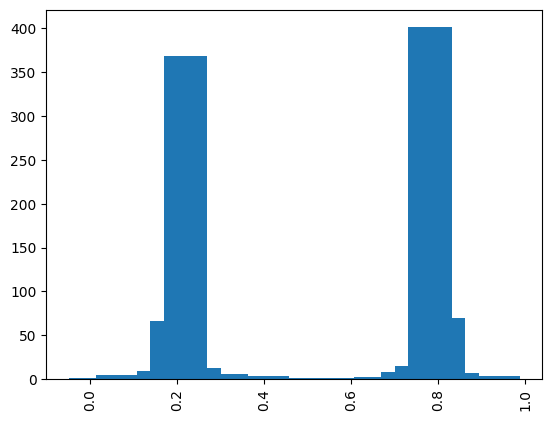

In [8]:
import matplotlib.pyplot as plt

phases_counts = dict(
    (sampled_state.state["phase_reg"], sampled_state.shots)
    for sampled_state in res[0].value.parsed_counts
)
plt.bar(phases_counts.keys(), phases_counts.values(), width=0.1)
plt.xticks(rotation=90)
print("phase with max probability: ", max(phases_counts, key=phases_counts.get))

From the phase we can extract the number of solutions:

In [9]:
solutions_ratio_qpe = np.sin(np.pi * max(phases_counts, key=phases_counts.get)) ** 2
print(
    "Number of solutions: ",
    (2**DOMAIN_SIZE) * solutions_ratio_qpe,
)

Number of solutions:  6.439277423870974


## Amplitude Estimation using Iterative Quantum Amplitude Estimation

Now we are ready for the iterative method! 

Instead of QPE, the algorithm applies the unitary:
$$
(Q)^mA
$$
where $m$, the number of repetitions is changed between iterations of the algorithm.

There is one subtlety that will change the way we work with the Grover operator. The classical algorithm expects additional indicator qubit that marks the "good" states, i.e.:
$$
|a\rangle|b\rangle|f(a,b)\rangle
$$

So now, most of our logic will go into the state preparation oracle ($A$). It will combine both the loading of the solution space, and the setting of the indicator qubit.

In [10]:
@qfunc
def iqae_state_preparation(a: QNum, b: QNum, res: QBit):
    reg = QArray("reg")
    bind([a, b, res], reg)
    hadamard_transform(reg[0:DOMAIN_SIZE])
    bind(reg, [a, b, res])
    arith_equation(a, b, res)

Now, as we use the indicator qubit, the oracle is very simple - it is just a $Z$ gate on the indicator qubit!

In [11]:
iqae_oracle = lambda x: Z(x[x.len - 1])

### Wrapping all to the Iterative Quantum Amplitude Estimation Algorithm

The circuit starts with the state $A|0\rangle$, then applies iterations of the Grover operator. 

Notice that the algorithm applies varied number of grover iterations on each execution. The number of iterations is chosen dynamically based on previous execution results, using statistical inference methods.

In [12]:
from classiq import CInt, power


@qfunc
def my_iqae_algorithm(
    k: CInt,
    oracle_operand: QCallable[QArray[QBit]],
    sp_operand: QCallable[QArray[QBit]],
    x: QArray[QBit],
):
    sp_operand(x)
    power(k, lambda: my_grover_operator(oracle_operand, sp_operand, x))

We use the built-in `iqae` classical execution code. It assumes only one output to the circuit, which is the indicator qubit.
We set $\epsilon = 1/{2^4} \cdot 0.5 = 1/32$. `alpha` is the tail probability of esimtating the result with accuracy $\epsilon$.

In [13]:
from classiq import cfunc
from classiq.qmod import QConstant, bind
from classiq.qmod.builtins.classical_execution_primitives import iqae, save

DOMAIN_SIZE_QCONST = QConstant("DOMAIN_SIZE_QCONST", int, DOMAIN_SIZE)


@cfunc
def cmain():
    iqae_res = iqae(epsilon=1 / ((2**DOMAIN_SIZE_QCONST) * 2), alpha=0.01)
    save({"iqae_res": iqae_res})


@qfunc
def main(
    k: CInt,
    ind_reg: Output[QBit],
) -> None:
    full_reg = QArray("full_reg")
    allocate(DOMAIN_SIZE + 1, full_reg)
    my_iqae_algorithm(
        k,
        iqae_oracle,
        lambda x: iqae_state_preparation(
            x[0:A_SIZE], x[A_SIZE : x.len - 1], x[x.len - 1]
        ),
        full_reg,
    )
    state_reg = QArray("state_reg", length=DOMAIN_SIZE)
    bind(full_reg, [state_reg, ind_reg])

### Synthesize the model to a quantum program

In [14]:
from classiq import Constraints, create_model, show, synthesize, write_qmod

constraints = Constraints(optimization_parameter="width")
qmod_iqae = create_model(
    main,
    constraints=constraints,
    classical_execution_function=cmain,
)

write_qmod(qmod_iqae, "quantum_counting_iqae")
qprog_iqae = synthesize(qmod_iqae)
show(qprog_iqae)

Opening: https://platform.classiq.io/circuit/25d45312-0499-496b-915b-5a054f17b36e?version=0.41.0.dev39%2B79c8fd0855


### Quantum Program execution

In [15]:
from classiq import execute

res = execute(qprog_iqae).result()

iqae_res = res[0].value
print(
    f"IQAE result: {iqae_res.estimation}, confidence interval: {iqae_res.confidence_interval}"
)

IQAE result: 0.3798699353077861, confidence interval: (0.3547029869901588, 0.4050368836254135)


In [16]:
print(
    f"Number of solutions: {(2**DOMAIN_SIZE) * iqae_res.estimation}, accuracy: "
    f"{(2**DOMAIN_SIZE)*(iqae_res.confidence_interval[1]-iqae_res.confidence_interval[0])}"
)

Number of solutions: 6.077918964924578, accuracy: 0.8053423461640756


In [17]:
assert np.isclose(
    iqae_res.estimation, solutions_ratio_qpe, 1 / ((2**DOMAIN_SIZE) * 0.5)
)
assert np.isclose(
    iqae_res.estimation, 6 / (2**DOMAIN_SIZE), 1 / ((2**DOMAIN_SIZE) * 0.5)
)

We can also see the statistics of the IQAE execution:

In [18]:
for i, iteration in enumerate(iqae_res.iterations_data):
    print(
        f"iteration_id: {i}, num grover iterations: {iteration.grover_iterations}, counts: {iteration.sample_results.counts}"
    )

iteration_id: 0, num grover iterations: 0, counts: {'0': 624, '1': 376}
iteration_id: 1, num grover iterations: 1, counts: {'0': 171, '1': 829}


## References

<a name='QCWiki'>[1]</a>: [Quantum Counting Algorithm Wikipedia](https://en.wikipedia.org/wiki/Quantum_counting_algorithm)

<a name='IQAE'>[2]</a>: [Grinko, D., Gacon, J., Zoufal, C. et al. Iterative quantum amplitude estimation. npj Quantum Inf 7, 52 (2021)](https://doi.org/10.1038/s41534-021-00379-1)

<a name='AE'>[3]</a>: [Brassard, G., Hoyer, P., Mosca, M., & Tapp, A. (2002). Quantum Amplitude Amplification and Estimation. Contemporary Mathematics, 305, 53-74.](https://arxiv.org/abs/quant-ph/0005055)
